### Experiment: Normalization

**Question**: Is normalization necessary? If so, what kind performs best?

**Hypothesis**: The data is already re-referenced using `mne.set_eeg_reference("average")` during pre-processing. The range used is approximately $[-55, 55]$, models might work better at a more commonly used range of $[0,1]$, or $[-1, 1]$ to keep negative numbers.

**Result**:

#### Part 1: Investigation

In [2]:
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
from pathlib import Path

In [6]:
data_path = Path("../data/sat1/split_stage_data.nc")
# data_path = Path("../data/ar/data.nc")
data = xr.load_dataset(data_path)

##### Histogram of distribution of all values

<xarray.DataArray 'histogram_data' (data_bin: 59)>
array([       2,        1,        0,        5,       15,       19,
             24,       32,       45,       61,      100,      158,
            253,      519,      867,     1583,     3230,     6714,
          15760,    38855,    97256,   250239,   634912,  1572221,
        3677891,  7561941, 11932895, 12228996,  8004789,  3907171,
        1684189,   701249,   298114,   131032,    58714,    27015,
          12419,     5919,     2804,     1380,      692,      298,
            154,       52,       25,       25,       18,       11,
              5,        3,        3,        2,        1,        3,
              3,        3,        0,        1,        2])
Coordinates:
  * data_bin  (data_bin) float64 -80.16 -77.14 -74.12 ... 88.9 91.92 94.94

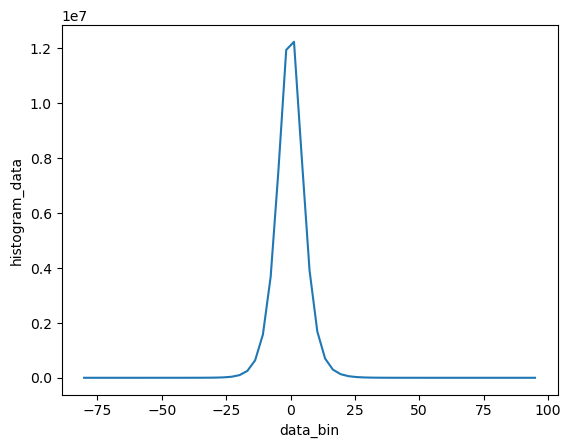

In [7]:
max = data.max().data.item()
min = data.min().data.item()
bins = np.linspace(min, max, 60)
hist = histogram(data.data, bins=bins, block_size=data.samples.size)
display(hist)
hist.plot()

##### Histogram of distribution for each channel

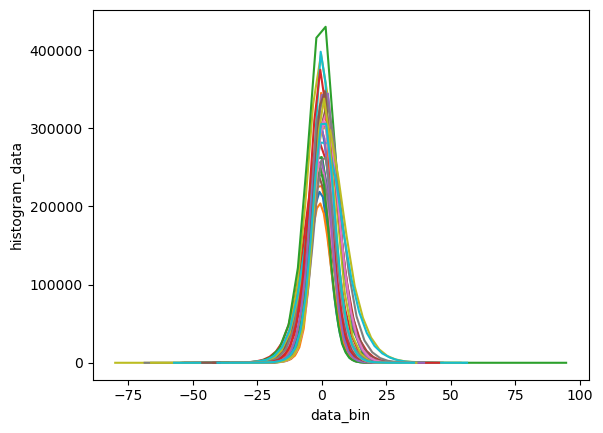

In [8]:
for channel in data.channels:
    data_subset = data.sel(channels=channel)
    max = data_subset.max().data.item()
    min = data_subset.min().data.item()
    bins = np.linspace(min, max, 40)
    hist = histogram(data_subset.data, bins=bins, block_size=data_subset.samples.size)
    hist.plot()

#### Part 2: Experiment

In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import xarray as xr
from hmpai.utilities import print_results
from hmpai.pytorch.models import *
from hmpai.pytorch.training import k_fold_cross_validate
from hmpai.normalization import *

In [2]:
data_path = Path("../data/sat1/split_stage_data.nc")

data = xr.load_dataset(data_path)

In [3]:
norm_fns = [norm_dummy, norm_0_to_1, norm_min1_to_1]


def test_normalization(norm_fn):
    print(f"Testing norm_fn: {norm_fn.__name__}")
    model = SAT1GRU
    model_kwargs = {
        "n_channels": len(data.channels),
        "n_samples": len(data.samples),
        "n_classes": len(data.labels),
    }
    train_kwargs = {
        "logs_path": Path("../logs/exp_normalization/"),
        "additional_info": {"norm_fn": norm_fn.__name__},
        "additional_name": f"norm_fn-{norm_fn.__name__}",
    }
    result = k_fold_cross_validate(
        model,
        model_kwargs,
        data,
        k=25,
        normalization_fn=norm_fn,
        train_kwargs=train_kwargs,
    )
    print_results(result)

In [6]:
test_normalization(norm_fns[0])

Testing norm_fn: norm_dummy
Fold 1: test fold: ['0009']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 1: Accuracy: 0.9158986175115207
Fold 1: F1-Score: 0.9171317243493181
Fold 2: test fold: ['0017']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 2: Accuracy: 0.8904933814681107
Fold 2: F1-Score: 0.8827751641255948
Fold 3: test fold: ['0001']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 3: Accuracy: 0.9253554502369669
Fold 3: F1-Score: 0.9210940123283292
Fold 4: test fold: ['0024']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 4: Accuracy: 0.8695652173913043
Fold 4: F1-Score: 0.8684264072148917
Fold 5: test fold: ['0012']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 5: Accuracy: 0.9384236453201971
Fold 5: F1-Score: 0.9412387069939563
Fold 6: test fold: ['0010']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 6: Accuracy: 0.9079754601226994
Fold 6: F1-Score: 0.911929965923882
Fold 7: test fold: ['0014']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 7: Accuracy: 0.9314359637774903
Fold 7: F1-Score: 0.9296576975039426
Fold 8: test fold: ['0002']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 8: Accuracy: 0.9049826187717266
Fold 8: F1-Score: 0.8989529028772305
Fold 9: test fold: ['0023']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 9: Accuracy: 0.9448356807511737
Fold 9: F1-Score: 0.9410085119145032
Fold 10: test fold: ['0006']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 10: Accuracy: 0.8880503144654088
Fold 10: F1-Score: 0.8835696537033316
Fold 11: test fold: ['0003']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 11: Accuracy: 0.934918648310388
Fold 11: F1-Score: 0.9326838551298773
Fold 12: test fold: ['0013']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 12: Accuracy: 0.9261992619926199
Fold 12: F1-Score: 0.9265874968664134
Fold 13: test fold: ['0016']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 13: Accuracy: 0.8815943728018757
Fold 13: F1-Score: 0.8835294015075454
Fold 14: test fold: ['0004']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 14: Accuracy: 0.8949579831932774
Fold 14: F1-Score: 0.895053671695571
Fold 15: test fold: ['0005']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 15: Accuracy: 0.9330900243309003
Fold 15: F1-Score: 0.9309282149702056
Fold 16: test fold: ['0021']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 16: Accuracy: 0.9428571428571428
Fold 16: F1-Score: 0.9384022082391723
Fold 17: test fold: ['0018']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 17: Accuracy: 0.9247572815533981
Fold 17: F1-Score: 0.9247637837109977
Fold 18: test fold: ['0022']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 18: Accuracy: 0.933570581257414
Fold 18: F1-Score: 0.9343602646505251
Fold 19: test fold: ['0019']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 19: Accuracy: 0.9589371980676329
Fold 19: F1-Score: 0.9563437736499921
Fold 20: test fold: ['0025']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 20: Accuracy: 0.908641975308642
Fold 20: F1-Score: 0.9118238921155989
Fold 21: test fold: ['0008']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 21: Accuracy: 0.9007832898172323
Fold 21: F1-Score: 0.8962475732984723
Fold 22: test fold: ['0011']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 22: Accuracy: 0.9232643118148599
Fold 22: F1-Score: 0.9251851095997067
Fold 23: test fold: ['0015']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 23: Accuracy: 0.9023255813953488
Fold 23: F1-Score: 0.8994700794347479
Fold 24: test fold: ['0020']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 24: Accuracy: 0.8941176470588236
Fold 24: F1-Score: 0.8929311823306382
Fold 25: test fold: ['0007']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 25: Accuracy: 0.8929440389294404
Fold 25: F1-Score: 0.8924521248486907
Average Accuracy: 0.9147990275402239
Average F1-Score: 0.9134618951593252


In [4]:
test_normalization(norm_fns[1])

Testing norm_fn: norm_0_to_1
Fold 1: test fold: ['0009']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 1: Accuracy: 0.9112903225806451
Fold 1: F1-Score: 0.9134615795939839
Fold 2: test fold: ['0017']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 2: Accuracy: 0.9193742478941035
Fold 2: F1-Score: 0.9130573446015717
Fold 3: test fold: ['0001']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 3: Accuracy: 0.9300947867298578
Fold 3: F1-Score: 0.9287296472421718
Fold 4: test fold: ['0024']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 4: Accuracy: 0.8695652173913043
Fold 4: F1-Score: 0.8715311331018167
Fold 5: test fold: ['0012']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 5: Accuracy: 0.9445812807881774
Fold 5: F1-Score: 0.94765157512042
Fold 6: test fold: ['0010']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 6: Accuracy: 0.9177914110429448
Fold 6: F1-Score: 0.922658380990975
Fold 7: test fold: ['0014']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 7: Accuracy: 0.9314359637774903
Fold 7: F1-Score: 0.9298740471098998
Fold 8: test fold: ['0002']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 8: Accuracy: 0.9073001158748552
Fold 8: F1-Score: 0.900534768675634
Fold 9: test fold: ['0023']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 9: Accuracy: 0.9671361502347418
Fold 9: F1-Score: 0.9668127565383433
Fold 10: test fold: ['0006']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 10: Accuracy: 0.9006289308176101
Fold 10: F1-Score: 0.8993988001305075
Fold 11: test fold: ['0003']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 11: Accuracy: 0.9662077596996246
Fold 11: F1-Score: 0.9673130801410545
Fold 12: test fold: ['0013']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 12: Accuracy: 0.915129151291513
Fold 12: F1-Score: 0.9202949147315873
Fold 13: test fold: ['0016']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 13: Accuracy: 0.8909730363423212
Fold 13: F1-Score: 0.8943938449092625
Fold 14: test fold: ['0004']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 14: Accuracy: 0.907563025210084
Fold 14: F1-Score: 0.9086968195120692
Fold 15: test fold: ['0005']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 15: Accuracy: 0.9537712895377128
Fold 15: F1-Score: 0.953760538745879
Fold 16: test fold: ['0021']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 16: Accuracy: 0.9511904761904761
Fold 16: F1-Score: 0.9493297140377223
Fold 17: test fold: ['0018']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 17: Accuracy: 0.9296116504854369
Fold 17: F1-Score: 0.9308483229641882
Fold 18: test fold: ['0022']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 18: Accuracy: 0.9288256227758007
Fold 18: F1-Score: 0.9305905580457299
Fold 19: test fold: ['0019']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 19: Accuracy: 0.967391304347826
Fold 19: F1-Score: 0.9679332887833103
Fold 20: test fold: ['0025']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 20: Accuracy: 0.9308641975308642
Fold 20: F1-Score: 0.9316273311051677
Fold 21: test fold: ['0008']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 21: Accuracy: 0.9595300261096605
Fold 21: F1-Score: 0.9589458392089417
Fold 22: test fold: ['0011']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 22: Accuracy: 0.9244823386114495
Fold 22: F1-Score: 0.924766170252768
Fold 23: test fold: ['0015']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 23: Accuracy: 0.9209302325581395
Fold 23: F1-Score: 0.9167134509466479
Fold 24: test fold: ['0020']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 24: Accuracy: 0.9150326797385621
Fold 24: F1-Score: 0.9167653875523749
Fold 25: test fold: ['0007']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 25: Accuracy: 0.9221411192214112
Fold 25: F1-Score: 0.9232397625771792
Average Accuracy: 0.9273136934713045
Average F1-Score: 0.9275571622647683


In [5]:
test_normalization(norm_fns[2])

Testing norm_fn: norm_min1_to_1
Fold 1: test fold: ['0009']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 1: Accuracy: 0.9366359447004609
Fold 1: F1-Score: 0.9373257676863751
Fold 2: test fold: ['0017']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 2: Accuracy: 0.9290012033694344
Fold 2: F1-Score: 0.9237988917697108
Fold 3: test fold: ['0001']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 3: Accuracy: 0.9502369668246445
Fold 3: F1-Score: 0.9489373703687907
Fold 4: test fold: ['0024']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 4: Accuracy: 0.9064558629776021
Fold 4: F1-Score: 0.905976461170147
Fold 5: test fold: ['0012']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 5: Accuracy: 0.958128078817734
Fold 5: F1-Score: 0.9589118614058775
Fold 6: test fold: ['0010']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 6: Accuracy: 0.9042944785276074
Fold 6: F1-Score: 0.9096296440589022
Fold 7: test fold: ['0014']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 7: Accuracy: 0.9366106080206986
Fold 7: F1-Score: 0.9353707565699516
Fold 8: test fold: ['0002']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 8: Accuracy: 0.8933951332560834
Fold 8: F1-Score: 0.8837719650184714
Fold 9: test fold: ['0023']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 9: Accuracy: 0.9706572769953051
Fold 9: F1-Score: 0.9689868383003859
Fold 10: test fold: ['0006']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 10: Accuracy: 0.9018867924528302
Fold 10: F1-Score: 0.9003846022538721
Fold 11: test fold: ['0003']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 11: Accuracy: 0.9599499374217773
Fold 11: F1-Score: 0.9604805120642659
Fold 12: test fold: ['0013']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 12: Accuracy: 0.942189421894219
Fold 12: F1-Score: 0.9447792851661363
Fold 13: test fold: ['0016']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 13: Accuracy: 0.9296600234466589
Fold 13: F1-Score: 0.931093034047555
Fold 14: test fold: ['0004']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 14: Accuracy: 0.9215686274509803
Fold 14: F1-Score: 0.9247188776094086
Fold 15: test fold: ['0005']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 15: Accuracy: 0.9562043795620438
Fold 15: F1-Score: 0.9577260480569827
Fold 16: test fold: ['0021']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 16: Accuracy: 0.9595238095238096
Fold 16: F1-Score: 0.9579605580027201
Fold 17: test fold: ['0018']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 17: Accuracy: 0.941747572815534
Fold 17: F1-Score: 0.941061805386485
Fold 18: test fold: ['0022']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 18: Accuracy: 0.9549228944246738
Fold 18: F1-Score: 0.9557776656858625
Fold 19: test fold: ['0019']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 19: Accuracy: 0.9722222222222222
Fold 19: F1-Score: 0.972813473972504
Fold 20: test fold: ['0025']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 20: Accuracy: 0.9358024691358025
Fold 20: F1-Score: 0.9380116992746024
Fold 21: test fold: ['0008']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 21: Accuracy: 0.9647519582245431
Fold 21: F1-Score: 0.964663979471019
Fold 22: test fold: ['0011']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 22: Accuracy: 0.9366626065773447
Fold 22: F1-Score: 0.9376678331045898
Fold 23: test fold: ['0015']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 23: Accuracy: 0.936046511627907
Fold 23: F1-Score: 0.9358915381759358
Fold 24: test fold: ['0020']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 24: Accuracy: 0.9294117647058824
Fold 24: F1-Score: 0.9270079381658052
Fold 25: test fold: ['0007']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 25: Accuracy: 0.9209245742092458
Fold 25: F1-Score: 0.9228383541947448
Average Accuracy: 0.9379556447674016
Average F1-Score: 0.9378234704392442


In [8]:
# View results in Tensorboard
! tensorboard --logdir ../logs/exp_normalization

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.15.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C
